# What drives the price of a car?

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<img src = images/crisp.png width = 30% align="left"/>

In [1]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, PredictionErrorDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from random import shuffle, seed

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None

In [2]:
vehicles = pd.read_csv('data/vehicles.csv')

### Business Understanding

The objective of this task is to determine which features contribute most to determining the cost of a used vehicle. A data set has been provided containing 426880 rows and 18 features. To accomplish this task, the data set will be ananized to determine feature importance and models will be developed to predict the value of used vehicle based on the data set.

### Data Understanding

For data understaning, the dataset will be cleaned by removing duplicate records and records missing data. Also, some catagorical features will be encoded as numberical features. This is only done for feature analysis. The data will be refreshed and more thoroughly cleaned in the Data Perparation section.

Check the dataset info to get familiar with the features.

In [3]:
vehicles.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

Some examination reveals that there are many redundant records with all values indentical except for id, region, and state. For example

In [4]:
vehicles.loc[vehicles['VIN'] == '1GCVKREH6GZ228691']

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
33,7316304717,auburn,34590,2016.0,chevrolet,silverado 1500 double,good,6 cylinders,gas,29499.0,clean,other,1GCVKREH6GZ228691,4wd,NaN,pickup,silver,al
609,7312938924,birmingham,34590,2016.0,chevrolet,silverado 1500 double,good,6 cylinders,gas,29499.0,clean,other,1GCVKREH6GZ228691,4wd,NaN,pickup,silver,al
1833,7316291314,dothan,34590,2016.0,chevrolet,silverado 1500 double,good,6 cylinders,gas,29499.0,clean,other,1GCVKREH6GZ228691,4wd,NaN,pickup,silver,al
2180,7313870985,florence / muscle shoals,34590,2016.0,chevrolet,silverado 1500 double,good,6 cylinders,gas,29499.0,clean,other,1GCVKREH6GZ228691,4wd,NaN,pickup,silver,al
2364,7312864965,gadsden-anniston,34590,2016.0,chevrolet,silverado 1500 double,good,6 cylinders,gas,29499.0,clean,other,1GCVKREH6GZ228691,4wd,NaN,pickup,silver,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418545,7313759956,kenosha-racine,34590,2016.0,chevrolet,silverado 1500 double,good,6 cylinders,gas,29499.0,clean,other,1GCVKREH6GZ228691,4wd,NaN,pickup,silver,wi
419804,7316310898,madison,34590,2016.0,chevrolet,silverado 1500 double,good,6 cylinders,gas,29499.0,clean,other,1GCVKREH6GZ228691,4wd,NaN,pickup,silver,wi
422425,7316143185,milwaukee,34590,2016.0,chevrolet,silverado 1500 double,good,6 cylinders,gas,29499.0,clean,other,1GCVKREH6GZ228691,4wd,NaN,pickup,silver,wi
425327,7313953110,sheboygan,34590,2016.0,chevrolet,silverado 1500 double,good,6 cylinders,gas,29499.0,clean,other,1GCVKREH6GZ228691,4wd,NaN,pickup,silver,wi


These redundant records are moved.

In [5]:
original_count = vehicles.shape[0]
vehicles = vehicles.drop_duplicates(subset=vehicles.columns.difference(['id','region','state']))
na_data_lost = 1 - (vehicles.shape[0] / original_count)
print(str(vehicles.shape[0]) + ' records remaining')
print('{:.2%} lost by dropping duplicate rows'.format(na_data_lost))

248742 records remaining
41.73% lost by dropping duplicate rows


In [6]:
vehicles = vehicles.dropna()
na_data_lost = 1 - (vehicles.shape[0] / original_count)
print(str(vehicles.shape[0]) + ' records remaining')

22951 records remaining


Convert some catagorical features to numeric.

In [7]:
vehicles['cylinders'].unique()

array(['6 cylinders', '4 cylinders', '8 cylinders', '5 cylinders',
       '10 cylinders', '3 cylinders', 'other', '12 cylinders'],
      dtype=object)

In [8]:
# Convert cyliders to a numeric feature
vehicles['cylinders'] = vehicles['cylinders'].str.replace(' cylinders', '')
vehicles['cylinders'] = pd.to_numeric(vehicles['cylinders'], errors='coerce')

In [9]:
vehicles['size'].unique()

array(['full-size', 'compact', 'mid-size', 'sub-compact'], dtype=object)

In [10]:
# Convert size to a numeric feature
vehicles['size'] = vehicles['size'].map({'sub-compact': 0, 'compact': 1, 'mid-size': 2, 'full-size': 3})

In [11]:
vehicles['condition'].unique()

array(['like new', 'excellent', 'fair', 'good', 'new', 'salvage'],
      dtype=object)

In [12]:
# Convert condition to a numeric feature
vehicles['condition'] = vehicles['condition'].map(
    {'salvage': 0, 'fair': 1, 'good': 2, 'excellent': 3, 'like new': 4, 'new': 5})

Generate a correltation headmap to determine which numerical fields affect price.

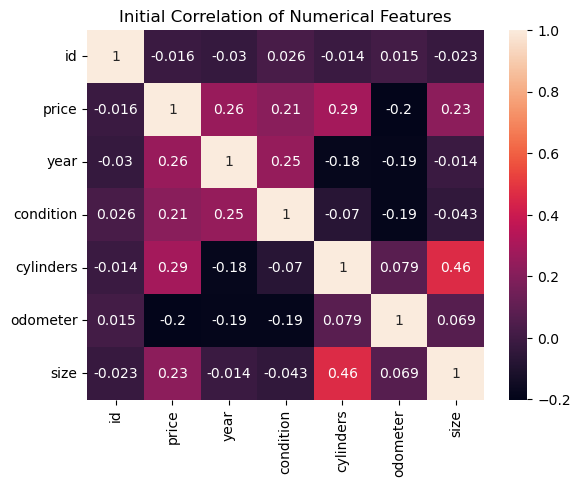

In [13]:
corr = vehicles.select_dtypes('number').corr()
sns.heatmap(corr, annot=True).set_title("Initial Correlation of Numerical Features");

This heat map shows no strong positive or negative correlations with price. This might be due to outliers.

In [14]:
vehicles.describe()

,id,price,year,condition,cylinders,odometer,size
count,2.295100e+04,22951.000000,22951.000000,22951.000000,22877.000000,2.295100e+04,22951.000000
mean,7.312157e+09,14262.506775,2010.468476,2.803015,5.832015,1.116134e+05,2.368611
std,4.176375e+06,12478.843279,7.737769,0.697410,1.631557,1.160752e+05,0.782197
min,7.301592e+09,0.000000,1905.000000,0.000000,3.000000,0.000000e+00,0.000000
25%,7.309472e+09,6000.000000,2007.000000,2.000000,4.000000,6.966950e+04,2.000000
50%,7.313519e+09,10980.000000,2012.000000,3.000000,6.000000,1.076780e+05,3.000000
75%,7.315512e+09,18890.000000,2015.000000,3.000000,8.000000,1.456820e+05,3.000000
max,7.317099e+09,155000.000000,2022.000000,5.000000,12.000000,9.999999e+06,3.000000


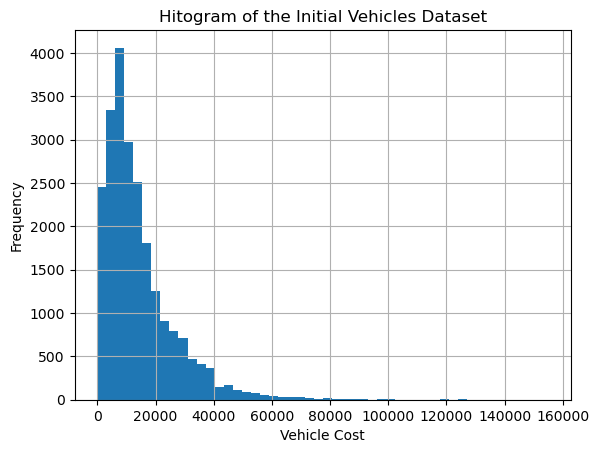

In [15]:
fig, ax = plt.subplots()
ax.set_title('Hitogram of the Initial Vehicles Dataset')
ax.set_xlabel('Vehicle Cost')
ax.set_ylabel("Frequency")
vehicles['price'].hist(bins=50);

The 'price' feature has a very high maximum value and minimum of 0. How many rows have 'price' under $1500?

In [16]:
vehicles[(vehicles['price'] < 1500)].shape[0]

1694

How many rows have 'price' over $100000?

In [17]:
vehicles[(vehicles['price'] > 100000)].shape[0]

16

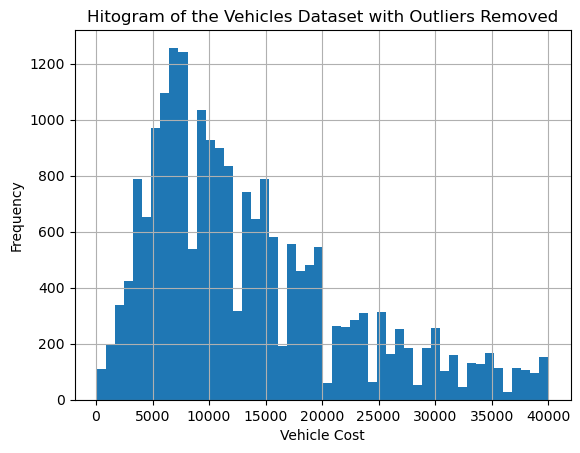

In [18]:
vehicles = vehicles.drop(vehicles[(vehicles.price < 100) | (vehicles.price > 40000)].index)
fig, ax = plt.subplots()
ax.set_title('Hitogram of the Vehicles Dataset with Outliers Removed')
ax.set_xlabel('Vehicle Cost')
ax.set_ylabel("Frequency")
vehicles['price'].hist(bins=50);

Event with the outliers removed, there is still not a normal distribution. However, the distribution is much closer to normal.

Outliers are removed from the 'year' feature.

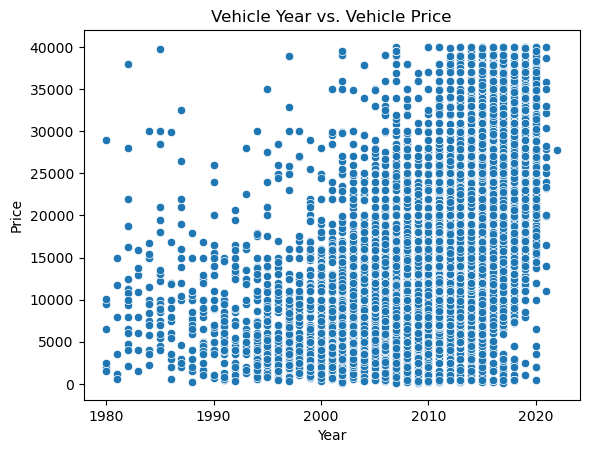

In [19]:
vehicles = vehicles.drop(vehicles[vehicles.year < 1980].index)
ax = sns.scatterplot(data=vehicles, x='year', y='price')
ax.set_title('Vehicle Year vs. Vehicle Price')
ax.set_xlabel('Year')
ax.set_ylabel('Price');

There is now a clear positive correlation between year and price.

Outliers are removed from the 'odometer' feature.

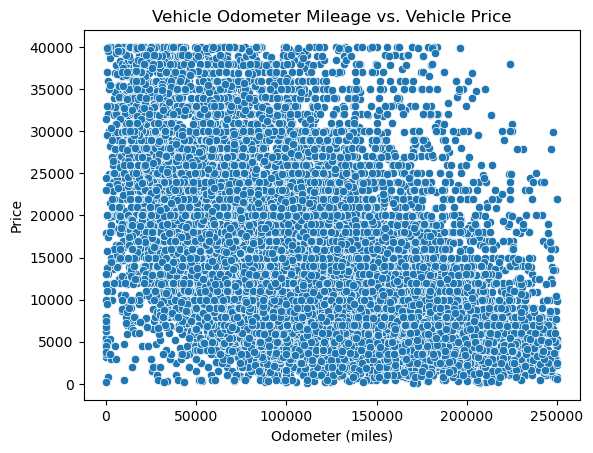

In [20]:
vehicles = vehicles.drop(vehicles[(vehicles.odometer < 100) | (vehicles.odometer > 250_000)].index)
ax = sns.scatterplot(data=vehicles, x='odometer', y='price')
ax.set_title('Vehicle Odometer Mileage vs. Vehicle Price')
ax.set_xlabel('Odometer (miles)')
ax.set_ylabel('Price');

There is now a more clear negative correlation between odometer and price, but it might not be very strong.

In [21]:
vehicles.describe()

,id,price,year,condition,cylinders,odometer,size
count,1.996300e+04,19963.000000,19963.000000,19963.000000,19903.000000,19963.000000,19963.000000
mean,7.312208e+09,13604.607624,2010.635225,2.779642,5.722353,112341.888945,2.357111
std,4.161844e+06,8851.936978,5.686160,0.687809,1.603115,51834.902261,0.785704
min,7.301592e+09,116.000000,1980.000000,0.000000,3.000000,100.000000,0.000000
25%,7.309520e+09,6977.500000,2007.000000,2.000000,4.000000,76398.000000,2.000000
50%,7.313579e+09,10999.000000,2012.000000,3.000000,6.000000,111010.000000,3.000000
75%,7.315525e+09,17995.000000,2015.000000,3.000000,6.000000,147042.500000,3.000000
max,7.317099e+09,40000.000000,2021.000000,5.000000,12.000000,250000.000000,3.000000


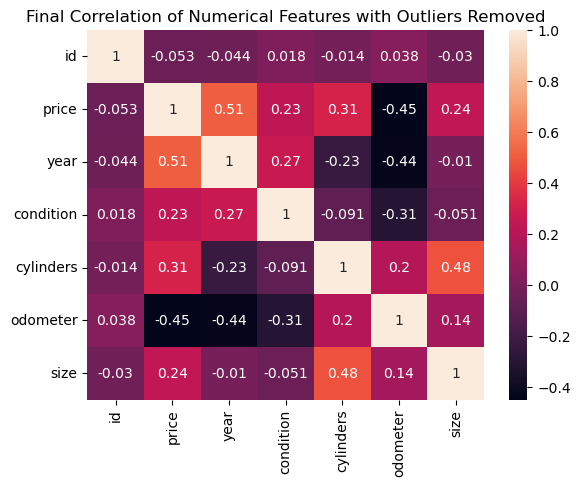

In [22]:
corr = vehicles.select_dtypes('number').corr()
sns.heatmap(corr, annot=True).set_title("Final Correlation of Numerical Features with Outliers Removed");

The correlations are stronger with outliers removed. The price has particularly strong correlations with year (postive) and odometer (negative).

Check the cardinality of the non-numeric features

In [23]:
nonnumerical_features = vehicles.select_dtypes('object').columns
# iterate over features listing the number of unique values for each
for feature in nonnumerical_features:
    print(feature + ' - ' + str(len(vehicles[feature].unique())))

region - 380
manufacturer - 40
model - 4516
fuel - 5
title_status - 6
transmission - 3
VIN - 19154
drive - 3
type - 13
paint_color - 12
state - 51


#### Summary of data understanding:
- _price_ has outliers under 100 and over 40,000 that can be removed
- _year_ has outliers under 1980
- _odometer_ has outliers under 100 and over 250,000
- _region_ and _model_ both have a high cardinality
- _VIN_ is an identifier with little influence over price
- _condition_ and _size_ are ordinal catagories
- _cylinders_ can be directly converted to a numerical feature
- The other fields are catagorical

### Data Preparation

Refresh the dataset for cleaning.

In [24]:
vehicles = pd.read_csv('data/vehicles.csv')

Drop rows with missing values.

In [25]:
vehicles = vehicles.dropna()

Remove duplicate rows.

In [26]:
vehicles = vehicles.drop_duplicates(subset=vehicles.columns.difference(['id','region','state']))

The columns 'id' and 'VIN' have no value for predicting price. They can be dropped.

In [27]:
vehicles = vehicles.drop(['id','VIN'], axis=1)

The columns 'region', 'model', and 'state' each have high cardinality. They can be dropped.

In [28]:
vehicles = vehicles.drop(['region', 'model', 'state'], axis=1)

Drop the rows with a 'price' under 500 dollars or over 40,000 dollars.

In [29]:
vehicles = vehicles.drop(vehicles[(vehicles.price < 500) | (vehicles.price > 40000)].index)

Drop the rows with 'year' under 1980.

In [30]:
vehicles = vehicles.drop(vehicles[vehicles.year < 1980].index)

Drop the rows with 'odometer' under 100 miles or over 250,000 miles.

In [31]:
vehicles = vehicles.drop(vehicles[(vehicles.odometer < 100) | (vehicles.odometer > 250_000)].index)

In [32]:
vehicles['price'] = vehicles['price'].astype(int)
vehicles['odometer'] = vehicles['odometer'].astype(int)
vehicles['year'] = vehicles['year'].astype(int)

Convert 'cylinders' to a numberic feature.

In [33]:
vehicles = vehicles.drop(vehicles[vehicles.cylinders == 'other'].index)
vehicles['cylinders'] = vehicles['cylinders'].str.replace(' cylinders', '')
vehicles['cylinders'] = pd.to_numeric(vehicles['cylinders'], errors='coerce').astype(int)

In [34]:
vehicles.info();

<class 'pandas.core.frame.DataFrame'>
Index: 19854 entries, 215 to 426833
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   price         19854 non-null  int32 
 1   year          19854 non-null  int32 
 2   manufacturer  19854 non-null  object
 3   condition     19854 non-null  object
 4   cylinders     19854 non-null  int32 
 5   fuel          19854 non-null  object
 6   odometer      19854 non-null  int32 
 7   title_status  19854 non-null  object
 8   transmission  19854 non-null  object
 9   drive         19854 non-null  object
 10  size          19854 non-null  object
 11  type          19854 non-null  object
 12  paint_color   19854 non-null  object
dtypes: int32(4), object(9)
memory usage: 1.8+ MB


Encode 'condition' and 'size' using the OrdinalEncoder.

In [35]:
conditionEncoder = OrdinalEncoder(categories=[['salvage', 'fair', 'good', 'excellent', 'like new', 'new']])
vehicles['condition'] = conditionEncoder.fit_transform(vehicles[['condition']]).astype(int)

In [36]:
sizeEncoder = OrdinalEncoder(categories=[['sub-compact', 'compact', 'mid-size', 'full-size']])
vehicles['size'] = sizeEncoder.fit_transform(vehicles[['size']]).astype(int)

Encode the remaining catagorical fields using the OneHotEncoder.

In [37]:
catagorical_features = ['manufacturer', 'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color']
ohencoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform="pandas")
ohe_columns = pd.DataFrame(ohencoder.fit_transform(vehicles[catagorical_features]))
ohe_columns.index = vehicles.index
vehicles = vehicles.drop(catagorical_features, axis=1)
vehicles = pd.concat([vehicles, ohe_columns], axis=1)
vehicles= vehicles.rename(str, axis="columns") 

Shuffle and split the data into training and test sets.

In [38]:
vehicles = vehicles.sample(frac=1, random_state=42).reset_index(drop=True)
X = vehicles.drop('price', axis=1)
y = vehicles['price']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

Prepare indeces for cross validation.

In [40]:
all_indices = list(range(0, len(X_train)))
seed(42)
shuffle(all_indices)
train_idx, test_idx = np.split(all_indices, [5000])

### Modeling

The data is modeled in three ways:
- Linear Regression with Sequential Feature Selection
- LASSO Regression
- Ridge Regression with GridCV cross validation

Mean Squared Error (MSE) is used as the evaluation metric. The dataset is large and most outliers have been removed. Considering this, MSE is an appropriate evaluation metric. R-squared is used to describe the proportion of the variance is explained by the the model.

#### Linear Regression with Sequential Fearure Selection

Use sequential feature selection to select the most best 20 features.

In [41]:
selector = SequentialFeatureSelector(estimator=LinearRegression(), 
                                    n_features_to_select=20,
                                    cv = [[train_idx, test_idx]],
                                    scoring = 'neg_mean_squared_error')

Build a pipeline to scale the dataset, select features, and fit the data to a linear regression model.

In [42]:
linreg_pipe = Pipeline([('scaler', StandardScaler()), ('column_selector', selector), ('linreg', LinearRegression())])
linreg_pipe.fit(X_train, y_train)
linreg_train_preds = linreg_pipe.predict(X_train)
linreg_test_preds = linreg_pipe.predict(X_test)
linreg_train_mse = mean_squared_error(y_train, linreg_train_preds)
linreg_train_r2 = r2_score(y_train, linreg_train_preds)
linreg_test_mse = mean_squared_error(y_test, linreg_test_preds)
linreg_test_r2 = r2_score(y_test, linreg_test_preds)

print('Linear Regression Training MSE: {:.2f}'.format(linreg_train_mse))
print('Linear Regression Training R2: {:.6f}'.format(linreg_train_r2))
print('Linear Regression Testing MSE: {:.2f}'.format(linreg_test_mse))
print('Linear Regression Testing R2: {:.6f}'.format(linreg_test_r2))

Linear Regression Training MSE: 22771903.56
Linear Regression Training R2: 0.709591
Linear Regression Testing MSE: 23460919.57
Linear Regression Testing R2: 0.695587


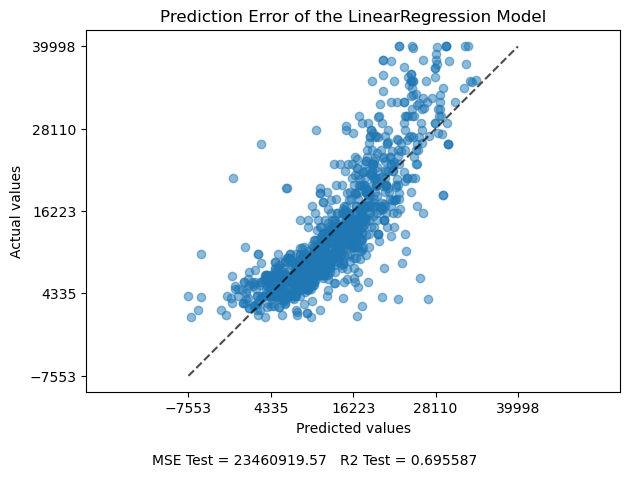

In [43]:
fig, ax = plt.subplots()
PredictionErrorDisplay.from_predictions(
    y_test,
    linreg_test_preds,
    ax = ax,
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5}
)
plt.title('Prediction Error of the LinearRegression Model')
# add the MSE and R2 under the plot
fig.text(0.50, 0.02, 
    'MSE Test = {:.2f}'.format(linreg_test_mse) + '   R2 Test = {:.6f}'.format(linreg_test_r2), 
    horizontalalignment='center', wrap=True )
fig.tight_layout(rect=(0,.05,1,1)) 
plt.show()
fig.savefig("images/pred_error_linreg.png", bbox_inches='tight');

In [44]:
r = permutation_importance(linreg_pipe, X_test, y_test, n_repeats=30, random_state=0)
r_data = np.array([X.columns, r.importances_mean, r.importances_std])
rdf = pd.DataFrame(r_data).T.set_index(0).rename(columns={0: 'Feature', 1: 'Mean', 2: 'STD'}).sort_values(by='Mean', ascending=False)
rdf['Mean'] = rdf['Mean'].astype("float").map('{:,.8f}'.format)
rdf['STD'] = rdf['STD'].astype("float").map('{:,.8f}'.format)
rdf.head(10)

,Mean,STD
0,,
year,0.40886903,0.00845462
odometer,0.28182289,0.00725476
cylinders,0.14003420,0.00427244
type_truck,0.06342588,0.00222824
fuel_diesel,0.06275101,0.00328803
drive_fwd,0.05219037,0.00243695
type_sedan,0.02814170,0.00192194
type_pickup,0.01860157,0.00192083
manufacturer_toyota,0.01804298,0.00153809


We can see from the permutation importance, that 'year', 'odometer', and 'cylinders' contributed most to the LinearRegression model performance.

#### LASSO Regression

In [45]:
lasso_pipe = Pipeline([('polyfeatures', PolynomialFeatures(degree = 2, include_bias = False)),
                ('scaler', StandardScaler()),
                ('lasso', Lasso(random_state = 0, tol=0.1))])
lasso_pipe.fit(X_train, y_train)
lasso_train_preds = lasso_pipe.predict(X_train)
lasso_test_preds = lasso_pipe.predict(X_test)
lasso_train_mse = mean_squared_error(y_train, lasso_train_preds)
lasso_train_r2 = r2_score(y_train, lasso_train_preds)
lasso_test_mse = mean_squared_error(y_test, lasso_test_preds)
lasso_test_r2 = r2_score(y_test, lasso_test_preds)

print('LASSO Training MSE: {:.2f}'.format(lasso_train_mse))
print('LASSO Training R2: {:.6f}'.format(lasso_train_r2))
print('LASSO Testing MSE: {:.2f}'.format(lasso_test_mse))
print('LASSO Testing R2: {:.6f}'.format(lasso_test_r2))

LASSO Training MSE: 15653194.83
LASSO Training R2: 0.800375
LASSO Testing MSE: 20223930.52
LASSO Testing R2: 0.737588


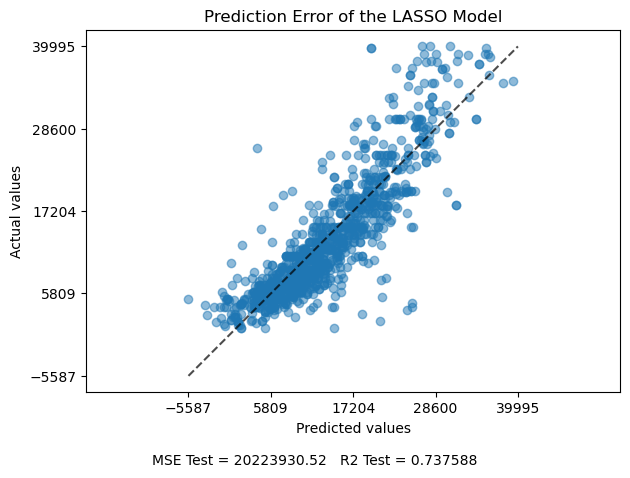

In [46]:
fig, ax = plt.subplots()
PredictionErrorDisplay.from_predictions(
    y_test,
    lasso_test_preds,
    ax = ax,
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
)
plt.title('Prediction Error of the LASSO Model')
# add the MSE and R2 under the plot
fig.text(0.50, 0.02, 
    'MSE Test = {:.2f}'.format(lasso_test_mse) + '   R2 Test = {:.6f}'.format(lasso_test_r2), 
    horizontalalignment='center', wrap=True )
fig.tight_layout(rect=(0,.05,1,1)) 
plt.show()
fig.savefig("images/pred_error_lasso.png", bbox_inches='tight');

In [47]:
lasso_df = pd.DataFrame(list(zip(lasso_pipe.named_steps['lasso'].coef_, X_train.columns)), columns=['coef', 'feature']).sort_values('coef', ascending=False).reset_index(drop=True)
lasso_df.head(10).sort_values('coef', ascending=False)

,coef,feature
0,4295.058917,year
1,3765.224073,cylinders
2,1564.234928,fuel_diesel
3,1088.931415,condition
4,909.313079,drive_4wd
5,630.609223,manufacturer_ram
6,521.505549,manufacturer_toyota
7,478.988019,title_status_clean
8,458.623707,type_coupe
9,443.290290,manufacturer_porsche


From the coeficients, we can see that 'year', 'cylinders', 'fuel_diesel' and 'condition' have the most effect on the LASSO model. Interstingly, some of the catagorical features had more of an effect than 'size'.

#### Ridge Regression with cross validation

In [48]:
ridge_pipe = Pipeline([
        ('polyfeatures', PolynomialFeatures(degree=2, include_bias = False)),
        ('scaler', StandardScaler()),
        ('ridge', Ridge())
])

In [49]:
alphas = [0.01,0.1,1,10,100]
ridge_grid = GridSearchCV(ridge_pipe, param_grid={'ridge__alpha': alphas}, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train);

In [50]:
best_model = ridge_grid.best_estimator_
best_model.fit(X,y)

ridge_train_preds = best_model.predict(X_train)
ridge_test_preds = best_model.predict(X_test)
ridge_train_mse = mean_squared_error(y_train, ridge_train_preds)
ridge_train_r2 = r2_score(y_train,ridge_train_preds)
ridge_test_mse = mean_squared_error(y_test, ridge_test_preds)
ridge_test_r2 = r2_score(y_test,ridge_test_preds)

print('Ridge Training MSE: {:.2f}'.format(ridge_train_mse))
print('Ridge Training R2: {:.6f}'.format(ridge_train_r2))
print('Ridge Testing MSE: {:.2f}'.format(ridge_test_mse))
print('Ridge Testing R2: {:.6f}'.format(ridge_test_r2))

Ridge Training MSE: 14954320.18
Ridge Training R2: 0.809288
Ridge Testing MSE: 15486596.69
Ridge Testing R2: 0.799057


In [51]:
ridge_df = pd.DataFrame(list(zip(best_model.named_steps['ridge'].coef_, X_train.columns)), columns=['coef', 'feature']).sort_values('coef', ascending=False).reset_index(drop=True)
ridge_df.head(10).sort_values('coef', ascending=False)

,coef,feature
0,1778.200502,year
1,331.937778,condition
2,322.902063,cylinders
3,234.933812,size
4,232.910586,type_truck
5,189.685489,type_van
6,147.000378,manufacturer_rover
7,138.311934,manufacturer_porsche
8,134.460772,manufacturer_volvo
9,127.632551,manufacturer_mercedes-benz


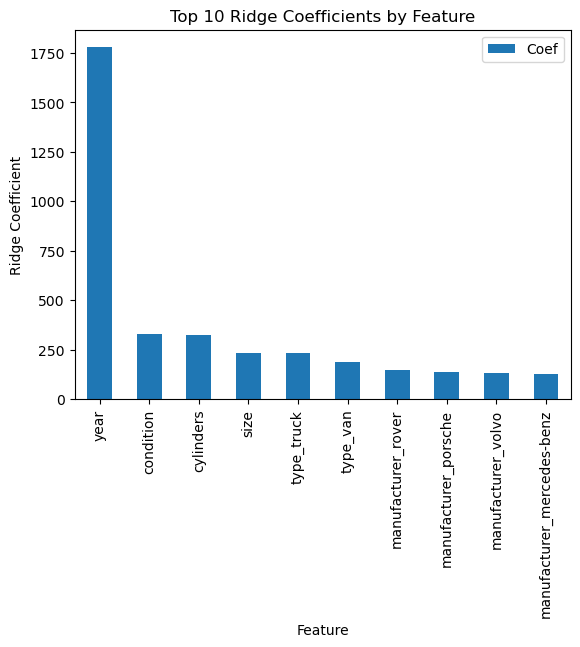

In [52]:
fig, ax = plt.subplots()
ridge_df.head(10).sort_values('coef', ascending=False).plot.bar(x='feature', y='coef', rot=90, ax=ax)
ax.set_title('Top 10 Ridge Coefficients by Feature')
ax.set_xlabel('Feature')
ax.set_ylabel('Ridge Coefficient')
ax.legend(labels=['Coef'])
plt.show()
fig.savefig("images/t10_ridge_coef.png", bbox_inches='tight');

From the coefficients, we can see that 'year', 'condition', 'cylinders', and 'size' have the most effect on the Ridge model. Cumulitively, 'type' and 'manufacturer' also had a significant affect on the model.

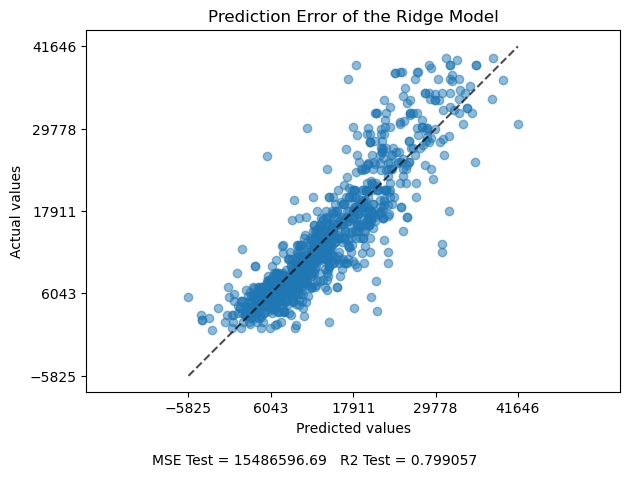

In [53]:
fig, ax = plt.subplots()
PredictionErrorDisplay.from_predictions(
    y_test,
    ridge_test_preds,
    ax = ax,
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
)
plt.title('Prediction Error of the Ridge Model')
# add the MSE and R2 under the plot
fig.text(0.50, 0.02, 
    'MSE Test = {:.2f}'.format(ridge_test_mse) + '   R2 Test = {:.6f}'.format(ridge_test_r2), 
    horizontalalignment='center', wrap=True )
fig.tight_layout(rect=(0,.05,1,1)) 
plt.show()
fig.savefig("images/pred_error_ridge.png", bbox_inches='tight');

### Evaluation

Comparison of model performance:

Model | Training MSE | Training R^2 | Test MSE | Test R^2 | Contributing Features
---:|:---:|:---:|:---:|:---:|:---
**LinearRegression** | 22771903.56 | 0.709591 | 23460919.57 | 0.695587 | year, odometer, and cylinders
**LASSO** | 15653194.83 | 0.800375 | 20223930.52 | 0.737588 | year, cylinders, fuel_diesel and condition
**Ridge** | 14954320.18 | 0.809288 | 15486596.69 | 0.799057 | year, condition, cylinders, and size 

The Ridge model produced the best results in both training and testing. The features year, condition, cylinders, and size had the most influence over the price. This will be communicated to the client to provice an understanding of the features that are important to buyers.

### Deployment

While this mode will not be deployed to provide pricing predictions, the features that affect pricing will be provided to the customer. The model will be available if the customer needs a prediction service in the future.